# CNN with PyTorch

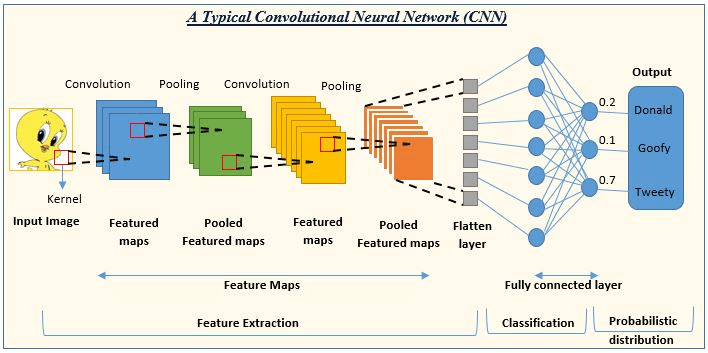

1. ***Input Image***:
The process starts with an input image. This image is represented as a grid of pixel values.
2. ***Kernel (Filter)***:
A small matrix (called a kernel or filter) slides over the input image. This kernel performs a convolution operation, which involves element-wise multiplication between the kernel and the portion of the image it covers, followed by summing the results to produce a single value. This process extracts features from the image, such as edges, textures, or shapes.
3. ***Convolutional Layer (Feature Maps)***:
After the convolution operation, the output is a feature map that highlights certain features of the image based on the filter applied.
The first set of feature maps (shown in blue) represents the initial extraction of features like edges or simple patterns.
4. ***Pooling Layer (Pooled Feature Maps)***:
Next, the feature map is passed through a pooling layer, which typically uses max pooling to reduce the spatial dimensions (width and height) of the feature maps.
This step helps to reduce the computational load, as well as to make the network invariant to small translations of the input image (e.g., the image shifting slightly left or right).
5. ***Additional Convolution and Pooling Layers***:
The process of convolution and pooling can be repeated several times to extract more complex and abstract features.
6. ***Flatten Layer***:
The pooled feature maps (which are still in 2D form) are then flattened into a 1D vector. This flattening step is necessary to prepare the data for the fully connected (dense) layers.
7. ***Fully Connected Layer***:
The flattened vector is passed through one or more fully connected layers, where each node is connected to every node in the previous layer. This is similar to a traditional neural network.
These layers learn to classify the features extracted by the convolutional layers into specific categories.
8. ***Output Layer***:
The final layer is the output layer, which in this case uses a softmax activation function. It outputs a probabilistic distribution across the possible classes. Based on the output probabilities, the network classifies the image. In this example, the highest probability is 0.7 for "Tweety," so the network classifies the input image as "Tweety."

### 1. Importing relevant libraries

In [1]:
    # !pip install opencv_python_headless==4.10.0.84
    # !pip install matplotlib==3.8.2
    # !pip install numpy==1.26.2
    # !pip install pandas==2.1.4
    # !pip install scikit_learn==1.4.2
    # !pip install seaborn==0.13.2
    # !pip install torch==2.2.2
    # !pip install torchvision==0.17.2

In [2]:
#Importing Necessary files to read Images
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.utils.data as Data
from torch import Tensor
from torch.autograd import Variable
%matplotlib inline

In [3]:
Training_folder = "C:/AIML Projects/Pytorch/Pytorch Learning Series/07_Pytorch CNN/Input/Data/Training_data"

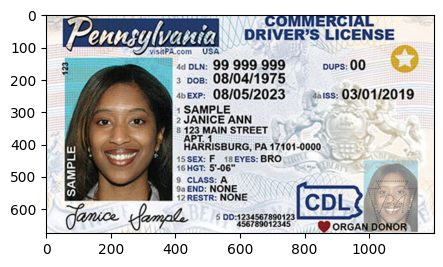

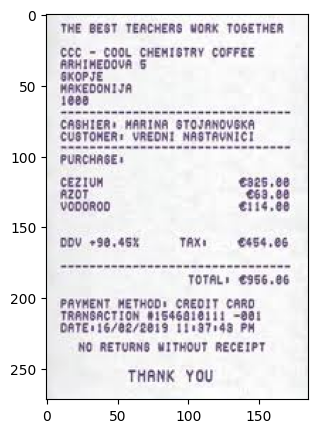

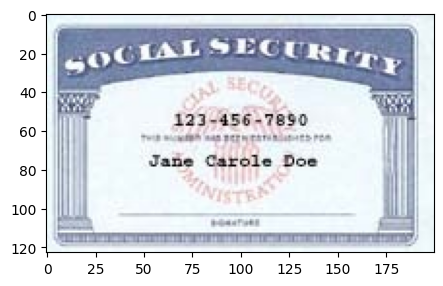

In [4]:
for path in os.listdir(Training_folder):
    for i in range(1):
        temp_path = Training_folder+"/"+path
        file = random.choice(os.listdir(temp_path)) #takes random image from temp_path
        image_path= os.path.join(temp_path, file)
        img=mpimg.imread(image_path)
        plt.figure(figsize=(5,5))
        plt.imshow(img)

### 2. Data Preprocessing

- Images are of different height & width, i.e., different resolutions. Before providing the data to the model, we should ensure that the data should be of same dimensions. Otherwise the model will break.
- Image data is created from image & labels, so that the size will not vary

In [5]:
#Setting the Image dimension and source folder for loading the dataset
IMG_WIDTH=200
IMG_HEIGHT=200
Train_folder='C:/AIML Projects/Pytorch/Pytorch Learning Series/07_Pytorch CNN/Input/Data/Training_data'
Test_folder='C:/AIML Projects/Pytorch/Pytorch Learning Series/07_Pytorch CNN/Input/Data/Testing_Data'

In [6]:
#Creating the image data and the labels from the images
def create_dataset(Train_folder):
    img_data_array=[] #all images are appended
    class_name=[] # respective classes are appended
    classes = {'driving_license': [1,0,0], 'others': [0,1,0], 'social_security': [0,0,1]}#Encoding
    for PATH in os.listdir(Train_folder):
        for file in os.listdir(os.path.join(Train_folder, PATH)):
            image_path= os.path.join(Train_folder, PATH,  file)
            image= cv2.imread(image_path, cv2.COLOR_BGR2RGB) #image is read & converted to RGB channel
            #Computes the pixel value by taking the average of all pixels that map to the output pixel.
            #interpolation refers to the method used to determine the pixel values of the resized image. 
            #INTER_AREA:Computes the pixel value by taking the average of all pixels that map to the output pixel.
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            #Converts to numpy array & float64 datatype
            image=np.array(image)
            image = image.astype('float64')
            image /= 255 #normalise-Every pixel has value 0-255
            if len(image.shape) == 3: #BGR
                #Reshaping is done to make in a format to feed the image to the network
                img_data_array.append(np.array(image).reshape([3, 200, 200])) #(No. of channels, width, height)
                class_name.append(classes[PATH])
    return img_data_array, class_name

In [7]:
# extract the image array and class name for training data
Train_img_data, train_class_name = create_dataset(Train_folder)

# extract the image array and class name for testing data
Test_img_data, test_class_name =create_dataset(Test_folder)
len(Train_img_data)

597

In [8]:
Train_img_data[0]

array([[[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        ...,
        [0.8745098 , 0.80784314, 0.94117647, ..., 0.95294118,
         0.95294118, 0.95686275],
        [0.99215686, 0.99215686, 0.99607843, ..., 0.84705882,
         0.80784314, 0.80392157],
        [0.85490196, 0.82745098, 0.82352941, ..., 0.90588235,
         0.89019608, 0.9254902 ]],

       [[0.86666667, 0.8       , 0.95294118, ..., 0.95294118,
         0.95294118, 0.95686275],
        [0.99607843, 0.99607843, 0.99607843, ..., 0.83529412,
         0.79607843, 0.80392157],
        [0.84705882, 0.85098039, 0.85490196, ..., 0.8745098 ,
         0.85882353, 0.9254902 ],
        ...,
        [0.81176471, 0.82352941, 0.82745098, ..., 0.94117647,
         0.90588235, 0.9372549 ],
        [0.9

In [9]:
train_class_name[0]

[1, 0, 0]

*Pytorch architecture accepts data in the form of tensor*

In [10]:
torch_dataset_train = Data.TensorDataset(Tensor(np.array(Train_img_data)), Tensor(np.array(train_class_name)))
torch_dataset_test = Data.TensorDataset(Tensor(np.array(Test_img_data)), Tensor(np.array(test_class_name)))

In [11]:
# defining trainloader and testloader - Push the data in batches of 8 untill all the images are provided to the model
trainloader = torch.utils.data.DataLoader(torch_dataset_train, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(torch_dataset_test, batch_size=8, shuffle=True)

In [12]:
# shape of training data
dataiter = iter(trainloader)
images = next(dataiter)
images[0].shape

torch.Size([8, 3, 200, 200])

*This is how a single batch of data looks like*

### 3. Model Building

In [13]:
# defining the model architecture
class CNNNet(nn.Module):   
  def __init__(self):
      super(CNNNet, self).__init__()

      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          #3 channel , 16 layers, filter size =5
          nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1)),
          nn.MaxPool2d(kernel_size=1, stride=1, padding=0, ceil_mode=False)
      )
    
      self.linear_layers = nn.Sequential(
          nn.Linear(3, 3)
      )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x


#define the optimizer and loss function 
# defining the model
model = CNNNet()
# defining the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
print(torch.cuda.is_available())
if torch.cuda.is_available():
    model = model.to("cuda")
    criterion = criterion.to("cuda")
    
print(model)


False
CNNNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1))
    (4): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
  )
)


In [14]:
#!export CUDA_LAUNCH_BLOCKING=1 #if GPU is present & if we get error , we'll be able to see it

In [15]:
#train this model for 10 epochs
for i in range(10):
    
    running_loss = 0
    model.train() # indicator for training phase
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.to("cuda")
          labels = labels.to("cuda")
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 1.0471188521385193
Epoch 2 - Training loss: 0.7678480251630148
Epoch 3 - Training loss: 0.5514905369281768
Epoch 4 - Training loss: 0.40545847788453104
Epoch 5 - Training loss: 0.3237840435902278
Epoch 6 - Training loss: 0.23869109647969405
Epoch 7 - Training loss: 0.20706893083949884
Epoch 8 - Training loss: 0.1518000876655181
Epoch 9 - Training loss: 0.09685475267469883
Epoch 10 - Training loss: 0.07620427190015713


In [16]:
#Saving the model
filepath ='C:/AIML Projects/Pytorch/Pytorch Learning Series/07_Pytorch CNN/output/model.pt'
torch.save(model.state_dict(), filepath)

In [17]:
#Loading the saved model

# model_trained = CNNNet()
# model_trained.load_state_dict(torch.load(filepath))

In [18]:
# device = "cuda"--> use if you have GPU

In [19]:
# [.2, .5, .3]
# y_pred_list = []
# y_true_list = []
# with torch.no_grad():
#     for x_batch, y_batch in testloader:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         y_test_pred = model(x_batch)
#         print(y_test_pred)
#         _, y_pred_tag = torch.max(y_test_pred, dim = 1)
#         y_pred_list.extend(y_pred_tag.cpu().numpy())
#         y_true_list.extend(y_batch.cpu().numpy())

#prediction 
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in testloader:
        x_batch, y_batch = x_batch.to(), y_batch.to()
        y_test_pred = model(x_batch)
        print(y_test_pred)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.extend(y_pred_tag.cpu().numpy())
        y_true_list.extend(y_batch.cpu().numpy())

tensor([[-0.9382,  2.2936, -0.5344],
        [ 0.2987, -1.9650,  1.1559],
        [ 5.0041, -3.7823, -2.3994],
        [ 1.6301, -0.5903, -1.1141],
        [ 5.5128, -1.8996, -4.2058],
        [-1.6115,  4.2817, -1.2291],
        [-1.2043, -2.2999,  2.8985],
        [ 7.8228, -3.5222, -5.4743]])
tensor([[ 0.8167, -3.2116,  1.4966],
        [-4.3145, -2.8454,  6.5306],
        [-3.8068, -5.6601,  7.8850],
        [ 2.5229, -0.4981, -2.1331],
        [-1.4602, -1.4085,  2.5684],
        [ 5.1903,  0.9687, -5.9025],
        [ 7.0410, -3.4847, -4.7190],
        [ 2.1497,  3.6008, -4.6068]])
tensor([[ 4.3418,  0.3452, -4.6173],
        [-1.6122, -4.4907,  4.8539],
        [ 6.7578,  0.3556, -7.0582],
        [-2.4399, -5.4703,  6.4092],
        [ 0.6408, -7.3932,  4.5580],
        [ 5.2933, -1.7446, -4.1394],
        [-0.7605, -2.1755,  2.3512],
        [-3.2359, -3.7993,  6.0744]])
tensor([[ 0.1770,  1.3604, -1.0419],
        [-3.5137, -0.3156,  3.9399],
        [-3.8068, -5.6601,  7.8850]

In [20]:
#y_test
y_true_list_max = [m.argmax() for m in y_true_list]

In [21]:
#Accuracy of model
correct_count, all_count = 0, 0
for i in range(len(y_pred_list)):
    if(y_pred_list[i] == y_true_list_max[i]):
      correct_count += 1
    all_count += 1
print("\nModel Accuracy =", (correct_count/all_count))


Model Accuracy = 0.912751677852349
